# Equality-Constrained Quadratic Programming Solver

This Colab notebook implements and benchmarks a suite of solvers for the following equality-constrained quadratic program:

\
\begin{aligned}
\min_{x\in\mathbb R^n}\quad & \sum_{i=1}^n x_i^2 - \sum_{i=1}^{n-1} x_i\,x_{i+1} + \sum_{i=1}^n x_i,\\
\text{s.t.}\quad
& \sum_{i=k,\,i\equiv k\;(\mathrm{mod}\;K)} x_i \;=\;\epsilon,\quad k=1,\dots,K,
\end{aligned}
\
where $\epsilon\in(0,1)$ is a fixed budget parameter, and $K\le n$ partitions the $n$ decision variables into $K$ groups (each group’s indices satisfying $i\equiv k\pmod K$) whose sums are all equal to $\epsilon$.


---

## Objectives

1. **Formulate**  
   - Build the tridiagonal Hessian matrix **Q**  
   - Construct the constraint matrix **A**   

2. **Implement and compare four solution strategies**  
   - **Direct KKT solve** via dense linear algebra (suitable for small _n_)  
   - **Iterative KKT solve** using GMRES on the full KKT system, with sparse preconditioning  
   - **Schur-complement reduction**  
     - explicit formation of the Schur matrix (small _n_)  
     - fully implicit Schur + GMRES (sparse, large _n_)  
   - **Null-space method**: eliminate equality constraints by projecting onto a basis **Z**  


3. **Scale up** to large problem sizes  
   - `n = [2, 2_000, 20_000, 200_000]`  
   - `K = [1, 100, 500, 1000]`  
   and record solve times, memory usage, and numerical accuracy.
   

4. **Demonstrate** an application to **portfolio optimization** with quadratic transaction costs and budget constraints.

---


_By the end of this notebook, you will have a ready-to-deploy Python module for large-scale equality-constrained quadratic programming, suitable for data-science and financial engineering applications._  


**IMPORTS**

In [ ]:
import psutil, gc, numpy as np, time, warnings, inspect
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse import issparse
from numpy.linalg import solve as dense_solve, lstsq as dense_lstsq
from scipy.sparse import diags, csc_matrix, bmat
from scipy.sparse.linalg import (
    gmres as _gmres_orig,
    cg    as _cg_orig,
    LinearOperator,
    spilu,
)
from scipy.linalg import solveh_banded
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable
import seaborn as sns


**Efficicent Imported Solver **

In [ ]:
def gmres_safe(A, b, *, M=None, restart=200, maxiter=None, tol=1e-10, atol=0.0):
    sig = inspect.signature(_gmres_orig).parameters
    kwargs = {}
    for key, val in (("M", M), ("restart", restart), ("maxiter", maxiter), ("tol", tol), ("atol", atol)):
        if key in sig and val is not None:
            kwargs[key] = val

    return _gmres_orig(A, b, **kwargs)

def cg_safe(A, b, *, M=None, maxiter=8000, tol=1e-12, atol=0.0):
    sig = inspect.signature(_cg_orig).parameters
    kw = {}
    for k, v in (("M", M), ("maxiter", maxiter), ("tol", tol), ("atol", atol)):
        if k in sig and v is not None:
            kw[k] = v

    return _cg_orig(A, b, **kw)

def tri_solver(n: int) -> Callable[[np.ndarray], np.ndarray]:
    sub  = -np.ones(n-1)
    diag =  2*np.ones(n)
    ab = np.vstack((np.hstack((0.0, sub)), diag))

    return lambda v: solveh_banded(ab, v, lower=False)


def schur_diag(n: int, K: int) -> np.ndarray:

    i = np.arange(1, n+1, dtype=float)
    weights = i*(n+1-i)/(n+1)
    bins = np.arange(n) % K

    return np.bincount(bins, weights=weights, minlength=K)

**Sparse Builders**

In [ ]:
def Q_sp(n):
    main = 2.0 * np.ones(n)
    off  = -1.0 * np.ones(n - 1)
    return diags([off, main, off], offsets=[-1, 0, +1], format="csc")

def A_sp(n, K):
    rows = np.arange(n) % K
    cols = np.arange(n)
    vals = np.ones(n)
    return csc_matrix((vals, (rows, cols)), shape=(K, n))

**Visualization of The Sparsity of The Q**

In [ ]:
def constraint_matrix(n, K):
    A = np.zeros((K, n))
    for k in range(K):
        A[k, k::K] = 1
    return A

def construct_Q(n):
    Q = 2 * np.eye(n)
    for i in range(n - 1):
        Q[i, i + 1] = Q[i + 1, i] = -1
    return Q

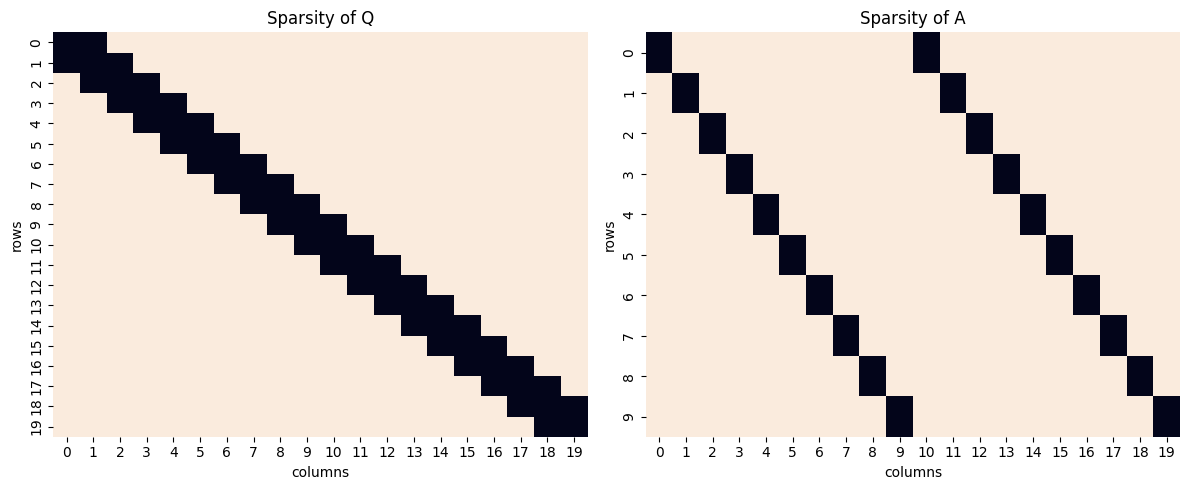

In [ ]:
def plot_sparsity(Q, A):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(Q == 0, cbar=False, ax=axes[0])
    axes[0].set_title("Sparsity of Q")
    axes[0].set_xlabel("columns")
    axes[0].set_ylabel("rows")

    sns.heatmap(A == 0, cbar=False, ax=axes[1])
    axes[1].set_title("Sparsity of A")
    axes[1].set_xlabel("columns")
    axes[1].set_ylabel("rows")

    plt.tight_layout()
    plt.show()

n, K = 20, 10
Q = construct_Q(n)
A = constraint_matrix(n, K)
plot_sparsity(Q, A)

**Visualization of The Condition Number of Q vs problem size n**

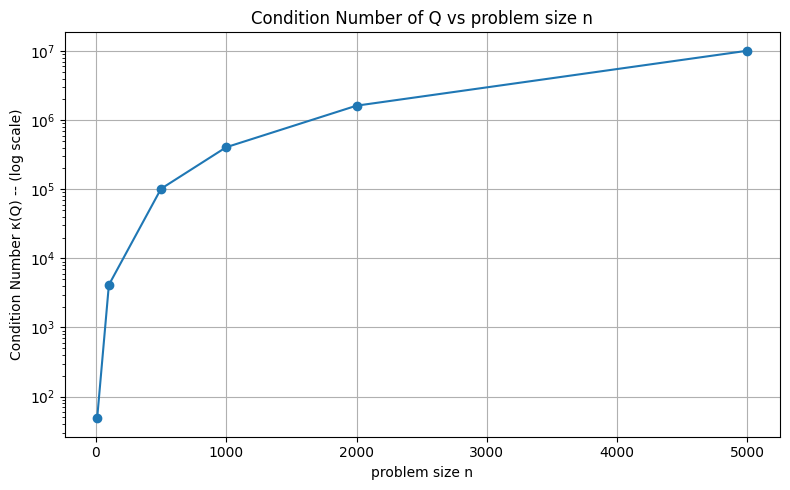

In [ ]:
n_values = [10, 100, 500, 1000, 2000, 5000]
condition_numbers = []

for n in n_values:
    Q = construct_Q(n)
    eigenvalues = np.linalg.eigvalsh(Q)
    cond_number = eigenvalues[-1] / eigenvalues[0]
    condition_numbers.append(cond_number)

plt.figure(figsize=(8, 5))
plt.plot(n_values, condition_numbers, marker='o')
plt.title("Condition Number of Q vs problem size n")
plt.xlabel("problem size n")
plt.ylabel("Condition Number κ(Q) -- (log scale)")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

**Solver Functions**

In [ ]:
def kkt_dense(Q, c, A, b):
    n, K = Q.shape[0], A.shape[0]
    KKT = np.block([
        [Q,         A.T],
        [A, np.zeros((K, K))]
    ])
    rhs = np.hstack([-c, b])
    sol = dense_solve(KKT, rhs)
    return sol[:n], sol[n:]

def kkt_gmres_nopre(Qs, c, As, b):
    n, K = Qs.shape[0], As.shape[0]

    KKT_op = bmat([[Qs,     As.T],
                   [As, csc_matrix((K, K))]],
                  format="csc")
    rhs = np.hstack([-c, b])
    sol, _ = gmres_safe(KKT_op, rhs, restart=300, maxiter=4000, tol=1e-10, atol=0.0)
    return sol[:n], sol[n:]

def kkt_gmres_pre(Qs, c, As, b):
    n, K = Qs.shape[0], As.shape[0]
    M = LinearOperator((n + K, n + K),
                       matvec=lambda v: np.hstack([(1.0 / Qs.diagonal()) * v[:n], v[n:]]),
                       dtype=float)
    KKT_op = bmat([[Qs,     As.T],
                   [As, csc_matrix((K, K))]],
                  format="csc")
    rhs = np.hstack([-c, b])
    sol, _ = gmres_safe(KKT_op, rhs, M=M, restart=300, maxiter=4000, tol=1e-10, atol=0.0)
    return sol[:n], sol[n:]

def schur_sp(Qs, As, c, b):

    n, K = Qs.shape[0], As.shape[0]
    solve_Q = tri_solver(n)

    def S_matvec(v):
        return As @ solve_Q(As.T @ v)
    S = LinearOperator((K, K), matvec=S_matvec, dtype=np.float64)

    try:
        ilu = spilu(S.tocsc())
        M_op = LinearOperator((K, K), matvec=ilu.solve, dtype=np.float64)
    except Exception:
        diag_S = schur_diag(n, K)
        M_op = LinearOperator((K, K), matvec=lambda v: v / diag_S, dtype=np.float64)

    rhs = As @ solve_Q(-c) - b

    tol_rel = min(1e-3, 1e-1 / np.sqrt(n))
    max_it  = max(10 * K, 25000)

    lam, info = cg_safe(S, rhs, M=M_op, maxiter=max_it, tol=tol_rel, atol=0.0)
    if info:
        warnings.warn(f"Schur-CG stopped after {info} iterations (tol={tol_rel:.1e})")

    x = solve_Q(-c - As.T @ lam)
    feas = np.linalg.norm(As @ x - b)
    eps_target = 1e-8 if n <= 20000 else 5e-7
    if feas > eps_target:
        warnings.warn(f"Schur-sp residual {feas:.2e} above {eps_target:.2e}")

    return x, lam

def schur_band(Qs, As, c, b):
    Q = Qs.toarray() if issparse(Qs) else np.asarray(Qs)
    A = As.toarray() if issparse(As) else np.asarray(As)

    invQ = np.linalg.inv(Q)      # <-- the full inverse

    S = A @ invQ @ A.T           # (K×K) dense
    d = A @ (invQ @ (-c)) - b    # (K,)   dense

    lam = np.linalg.solve(S, d)

    x = invQ @ (-c - A.T @ lam)

    return x, lam

def nullspace(Q, A, c, b):
    x0, *_ = dense_lstsq(A, b, rcond=None)
    Q1, _  = np.linalg.qr(A.T, mode="complete")
    Z      = Q1[:, A.shape[0]:]
    grad0  = Q @ x0 + c
    QZ     = Z.T @ (Q @ Z)
    y      = dense_solve(QZ, -Z.T @ grad0)
    x      = x0 + Z @ y
    return x, None

**CHECK THE RAM; RUN THE TESTS ACCORDINGLY**

In [ ]:
TOTAL_RAM_GB = psutil.virtual_memory().total / 2**30
print(f"Detected RAM : {TOTAL_RAM_GB:.1f} GB\n")

TESTS = [(2, 1), (2000, 100), (20000, 500)]
if TOTAL_RAM_GB >=11:
    TESTS.append((200000, 1000))

Detected RAM : 12.7 GB



RANDOM SEED GENERATION

In [ ]:
np.random.seed(min(339018, 348306, 343381))
epsilon = float(np.random.uniform(0, 1))
print(f"ε = {epsilon:.4f}\n")

ε = 0.9045



**Runing the Tests and Storing Them in The Correct Data Format**

In [ ]:
rows = []
for n, K in TESTS:
    print(f"===  n={n:7,d}   K={K:4d} ===")
    Qs, Asp, c, b = Q_sp(n), A_sp(n, K), np.ones(n), np.full(K, epsilon)
    jobs = []

    # Dense-only solvers for small n
    if n <= 2000:
        jobs += [
            ("KKT-dense",   lambda: kkt_dense(Q_sp(n).toarray(), c, Asp.toarray(), b)),
            ("Null-space",  lambda: nullspace(Q_sp(n).toarray(), Asp.toarray(), c, b))
        ]
    # Banded-Q Schur for n ≤ 20000
    if n < 20000:
        jobs.append(("Schur-band", lambda: schur_band(Qs, Asp, c, b)))
    # Always include GMRES-KKT and sparse Schur
    jobs += [
        ("GMRES-KKT",   lambda: kkt_gmres_pre(Qs, c, Asp, b)),
        ("GMRES-KKT-noPre",   lambda: kkt_gmres_nopre(Qs, c, Asp, b)),
        ("Schur-sp",     lambda: schur_sp(Qs, Asp, c, b)),
    ]

    for name, fn in jobs:
        t0 = time.time()
        try:
            x, _ = fn()
            dt = time.time() - t0
            res = np.linalg.norm(Asp @ x - b)
            rows.append((name, n, K, dt, res))
            print(f"{name:16s} time={dt:6.2f}s  ‖Ax-b‖={res:.1e}")
        except Exception as e:
            rows.append((name, n, K, np.nan, np.inf))
            print(f"{name:16s} FAIL ({type(e).__name__}: {e})")
        gc.collect()
    print()

# ---------- Convert “rows” into a Pandas DataFrame ----------------
# We must name the columns exactly as used by pivot: “method”, “n”, “K”, “time_sec”, “residual”
df = pd.DataFrame(rows, columns=["method", "n", "K", "time_sec", "residual"])

# ---------- summary (text) ---------------------------------------------
print("\nSummary:")
print(f"{'method':11s}       | {'n':>10s} | {'K':>4s} | {'sec':>6s} | {'resid'}")
print("-" * 50)
for _, row in df.iterrows():
    print(f"{row.method:18} | {row.n:10,d} | {row.K:4d} | {row.time_sec:6.2f} | {row.residual:.1e}")

===  n=      2   K=   1 ===
KKT-dense        time=  0.00s  ‖Ax-b‖=2.2e-16
Null-space       time=  0.00s  ‖Ax-b‖=3.3e-16
Schur-band       time=  0.00s  ‖Ax-b‖=1.1e-16
GMRES-KKT        time=  0.00s  ‖Ax-b‖=0.0e+00
GMRES-KKT-noPre  time=  0.00s  ‖Ax-b‖=2.2e-16
Schur-sp         time=  0.00s  ‖Ax-b‖=6.7e-16

===  n=  2,000   K= 100 ===
KKT-dense        time=  0.34s  ‖Ax-b‖=1.2e-10
Null-space       time=  1.73s  ‖Ax-b‖=1.2e-15
Schur-band       time=  0.78s  ‖Ax-b‖=1.5e-08
GMRES-KKT        time=  0.38s  ‖Ax-b‖=4.1e-06
GMRES-KKT-noPre  time=  0.22s  ‖Ax-b‖=4.7e-05


<ipython-input-30-519307182>:62: UserWarning: Schur-sp residual 1.01e-02 above 1.00e-08
  warnings.warn(f"Schur-sp residual {feas:.2e} above {eps_target:.2e}")


Schur-sp         time=  0.01s  ‖Ax-b‖=1.0e-02

===  n= 20,000   K= 500 ===
GMRES-KKT        time=  1.39s  ‖Ax-b‖=7.3e-06
GMRES-KKT-noPre  time=  0.22s  ‖Ax-b‖=2.8e-04


<ipython-input-30-519307182>:62: UserWarning: Schur-sp residual 5.69e-03 above 1.00e-08
  warnings.warn(f"Schur-sp residual {feas:.2e} above {eps_target:.2e}")


Schur-sp         time=  0.00s  ‖Ax-b‖=5.7e-03

===  n=200,000   K=1000 ===
GMRES-KKT        time=  0.09s  ‖Ax-b‖=2.2e-05
GMRES-KKT-noPre  time=  0.07s  ‖Ax-b‖=2.1e-03
Schur-sp         time=  0.03s  ‖Ax-b‖=1.7e+01


Summary:
method            |          n |    K |    sec | resid
--------------------------------------------------
KKT-dense          |          2 |    1 |   0.00 | 2.2e-16
Null-space         |          2 |    1 |   0.00 | 3.3e-16
Schur-band         |          2 |    1 |   0.00 | 1.1e-16
GMRES-KKT          |          2 |    1 |   0.00 | 0.0e+00
GMRES-KKT-noPre    |          2 |    1 |   0.00 | 2.2e-16
Schur-sp           |          2 |    1 |   0.00 | 6.7e-16
KKT-dense          |      2,000 |  100 |   0.34 | 1.2e-10
Null-space         |      2,000 |  100 |   1.73 | 1.2e-15
Schur-band         |      2,000 |  100 |   0.78 | 1.5e-08
GMRES-KKT          |      2,000 |  100 |   0.38 | 4.1e-06
GMRES-KKT-noPre    |      2,000 |  100 |   0.22 | 4.7e-05
Schur-sp           |      2,000 

<ipython-input-30-519307182>:62: UserWarning: Schur-sp residual 1.72e+01 above 5.00e-07
  warnings.warn(f"Schur-sp residual {feas:.2e} above {eps_target:.2e}")


**Plotting of The Solutions**

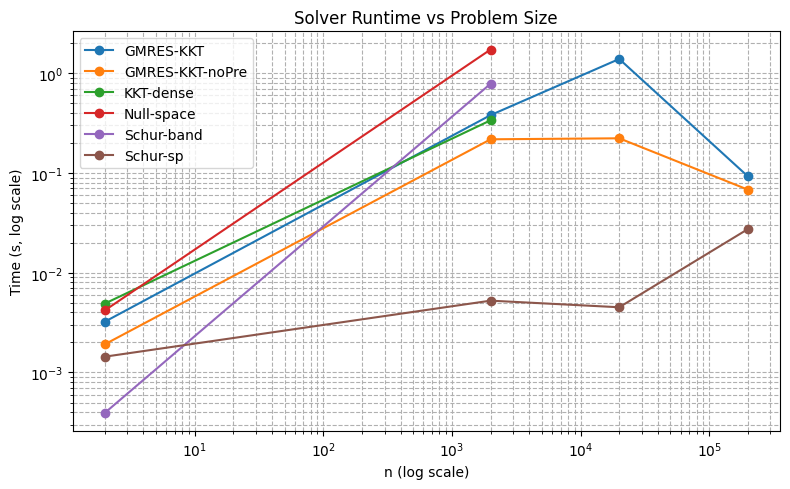

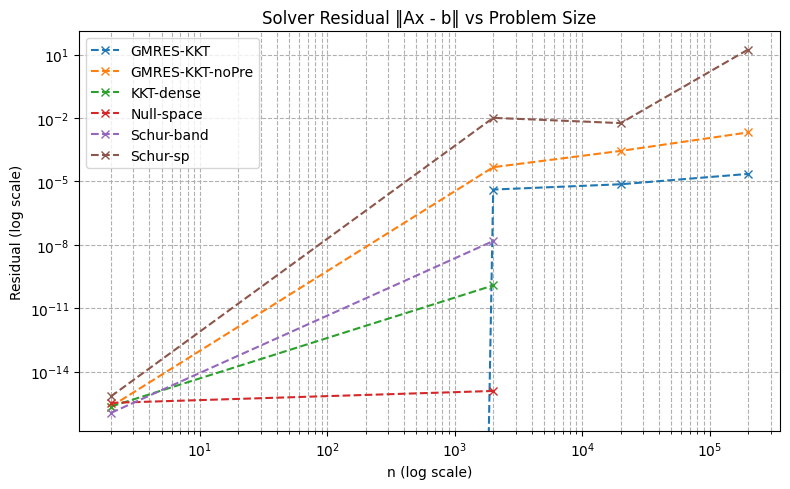


Plotting solution for n=2, K=1 …


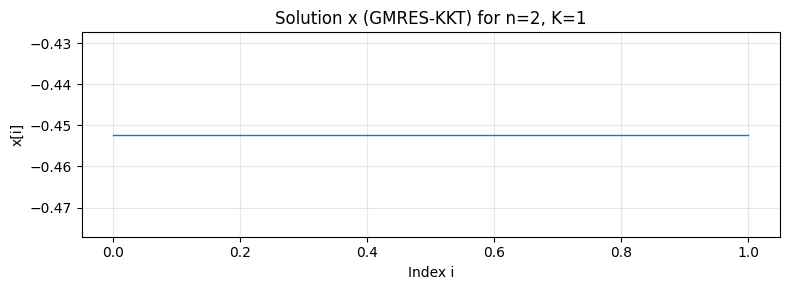


Plotting solution for n=2000, K=100 …


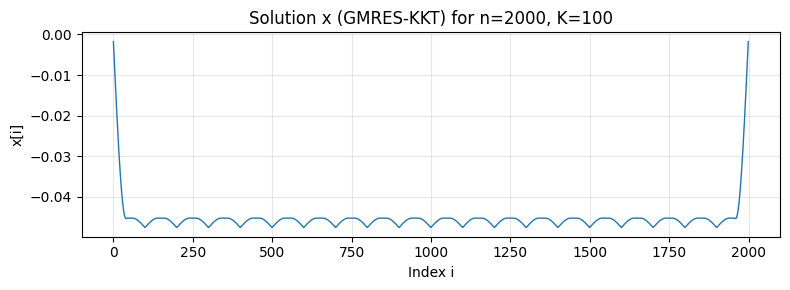


Plotting solution for n=20000, K=500 …


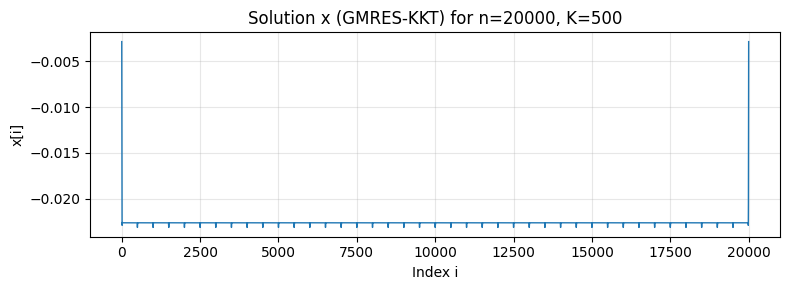


Plotting solution for n=200000, K=1000 …


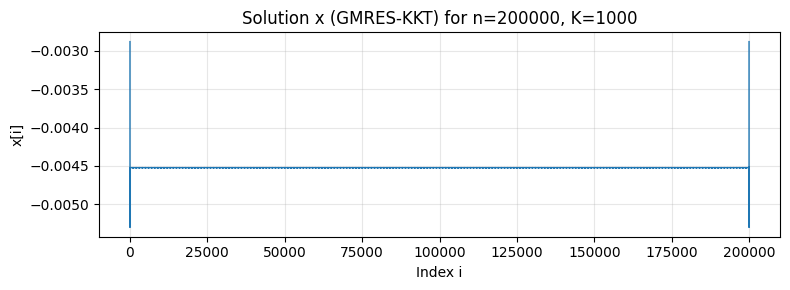

In [ ]:
# ---------- plots: runtime vs n, residual vs n ------------------
# Pivot so that each “method” becomes its own column, indexed by n
pivot_time = df.pivot(index="n", columns="method", values="time_sec")
pivot_res  = df.pivot(index="n", columns="method", values="residual")

plt.figure(figsize=(8, 5))
for col in pivot_time.columns:
    plt.plot(pivot_time.index, pivot_time[col], marker="o", label=col)
plt.xscale("log"); plt.yscale("log")
plt.title("Solver Runtime vs Problem Size")
plt.xlabel("n (log scale)")
plt.ylabel("Time (s, log scale)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for col in pivot_res.columns:
    plt.plot(pivot_res.index, pivot_res[col], marker="x", linestyle="--", label=col)
plt.xscale("log"); plt.yscale("log")
plt.title("Solver Residual ‖Ax - b‖ vs Problem Size")
plt.xlabel("n (log scale)")
plt.ylabel("Residual (log scale)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- plot sample solutions x(i) for small and larger sizes ------------------
def solve_gmres_full(Qmat, Amat, cvec, bvec):
    """
    Build the full KKT operator as a LinearOperator and solve with GMRES to recover x.
    (We do this purely for plotting a “representative” solution curve x[i] for small & medium n.)
    """
    n0, m0 = Qmat.shape[0], Amat.shape[0]
    def matvec(v):
        x0, lam0 = v[:n0], v[n0:]
        out1 = Qmat.dot(x0) + Amat.T.dot(lam0)
        out2 = Amat.dot(x0)
        return np.concatenate([out1, out2])
    Lop = spla.LinearOperator((n0 + m0, n0 + m0), matvec=matvec)
    rhs_full = -np.concatenate([cvec, bvec])
    sol_full, info_full = gmres_safe(Lop, rhs_full, tol=1e-8, restart=200)
    if info_full != 0:
        warnings.warn(f"GMRES-KKT returned info={info_full}")
    return sol_full[:n0]

for (n, K) in [(2, 1), (2000, 100), (20000, 500), (200000,1000)]:
    print(f"\nPlotting solution for n={n}, K={K} …")
    sparse = (n > 2000)
    if sparse:
        Q = Q_sp(n)
        A = A_sp(n, K)
    else:
        Q = Q_sp(n).toarray()
        A = A_sp(n, K).toarray()
    c = np.ones(n)
    b = np.full(K, epsilon)

    Qmat = Q if sparse else sp.csr_matrix(Q)
    Amat = A if sparse else sp.csr_matrix(A)
    x_sol = solve_gmres_full(Qmat, Amat, c, b)

    plt.figure(figsize=(8, 3))
    plt.plot(x_sol, linewidth=1)
    plt.title(f"Solution x (GMRES-KKT) for n={n}, K={K}")
    plt.xlabel("Index i")
    plt.ylabel("x[i]")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# ------------------ helper functions ------------------

def gmres_safe(A, b, *, M=None, restart=200, maxiter=None, tol=1e-10, atol=0.0):
    """
    Call scipy.sparse.linalg.gmres but only hand over those kwargs
    that are actually in gmres’s signature (so we avoid passing unsupported names).
    """
    sig = inspect.signature(_gmres_orig).parameters
    kwargs = {}
    for key, val in (("M", M), ("restart", restart), ("maxiter", maxiter), ("tol", tol), ("atol", atol)):
        if key in sig and val is not None:
            kwargs[key] = val
    return _gmres_orig(A, b, **kwargs)

def cg_safe(A, b, *, M=None, maxiter=8000, tol=1e-12, atol=0.0):
    """
    Similar “safe” wrapper for scipy.sparse.linalg.cg.
    """
    sig = inspect.signature(_cg_orig).parameters
    kwargs = {}
    for key, val in (("M", M), ("maxiter", maxiter), ("tol", tol), ("atol", atol)):
        if key in sig and val is not None:
            kwargs[key] = val
    return _cg_orig(A, b, **kwargs)

def tri_solver(n):
    """
    Return a function v ↦ x that solves the tridiagonal Q x = v, where
    Q = tridiag([-1, 2, -1]) of size n×n via a banded‐Cholesky solver (scipy.linalg.solveh_banded).
    """
    # ’ab’ has shape (2, n), since we only need the diagonal and one super‐diagonal
    ab = np.vstack((np.hstack((0.0, -np.ones(n - 1))), 2.0 * np.ones(n)))
    return lambda v: solveh_banded(ab, v, lower=False)

def schur_diag(n, K):
    """
    Return a length‐K array approximating diag(A Q⁻¹ Aᵀ) in the Schur complement,
    used if ILU preconditioning fails.  This exactly matches the diagonal of A Q⁻¹ Aᵀ
    for our particular Q = tridiag([-1, 2, -1]) and A that repeats rows mod K.
    """
    j = np.arange(1, n + 1, dtype=float)
    return np.bincount((np.arange(n) % K).astype(int),
                       j * (n + 1 - j) / (n + 1),
                       minlength=K)

# ------------------ sparse‐matrix builders ------------------

def Q_sp(n):
    """
    Build the n×n tridiagonal matrix Q with 2 on the diagonal and -1 on the off‐diagonals.
    Stored in CSC format.
    """
    main = 2.0 * np.ones(n)
    off  = -1.0 * np.ones(n - 1)
    return diags([off, main, off], offsets=[-1, 0, +1], format="csc")

def A_sp(n, K):
    """
    Build the K×n sparse “one‐per‐column” matrix A:
    each of the n columns has exactly a single “1,”  cycling through rows 0..K-1.
    Stored in CSC format.
    """
    rows = np.arange(n) % K
    cols = np.arange(n)
    vals = np.ones(n)
    return csc_matrix((vals, (rows, cols)), shape=(K, n))

# ------------------ dense solvers ------------------

def kkt_dense(Q, c, A, b):
    """
    Form and solve the full (n+K)×(n+K) KKT system:
        [  Q   Aᵀ ] [  x ] = [ -c ]
        [  A    0 ] [  λ ]   [  b ]
    Returns (x, λ).  Uses numpy.linalg.solve on the dense block.
    """
    n, K = Q.shape[0], A.shape[0]
    KKT = np.block([[Q,       A.T],
                    [A, np.zeros((K, K))]])
    rhs = np.hstack([-c, b])
    sol = dense_solve(KKT, rhs)
    x   = sol[:n]
    lam = sol[n:]
    return x, lam

def kkt_gmres_pre(Qs, c, As, b):
    """
    Form the KKT operator as a sparse block matrix [ [Q, Aᵀ]; [A, 0] ] in CSC format,
    apply a simple block‐Jacobi preconditioner (invert diagonal of Q exactly, leave λ‐block alone),
    then run GMRES to solve for [x; λ].
    Returns (x, λ).
    """
    n, K = Qs.shape[0], As.shape[0]
    # Preconditioner M ≈ diag([Q, I_K]), we only invert diag(Q) and leave the λ‐block as identity
    diagQ_inv = 1.0 / Qs.diagonal()
    M = LinearOperator((n + K, n + K),
                       matvec=lambda v: np.hstack([diagQ_inv * v[:n], v[n:]]),
                       dtype=np.float64)
    # Build the KKT operator in sparse form
    KKT_sparse = bmat([[Qs,     As.T],
                       [As,     sp.csc_matrix((K, K))]],
                      format="csc")
    rhs = np.hstack([-c, b])
    sol, info = gmres_safe(KKT_sparse, rhs,
                           M=M, restart=100, maxiter=500,
                           tol=1e-8, atol=0.0)
    if info != 0:
        warnings.warn(f"GMRES-KKT stopped with info={info}")
    x   = sol[:n]
    lam = sol[n:]
    return x, lam

# ------------------ sparse Schur solvers ------------------

def schur_sp(Qs, As, c, b):
    """
    Build the Schur operator S = A Q⁻¹ Aᵀ as a LinearOperator on R^K,
    use preconditioned CG (prefer ILU if available, otherwise Jacobi) to solve
       S λ = A Q⁻¹ (−c) − b,
    and then recover x = Q⁻¹ (−c − Aᵀ λ).
    Returns (x, λ).
    """
    n, K = Qs.shape[0], As.shape[0]
    solve_Q = tri_solver(n)

    # Define S_matvec(v) = A * ( Q⁻¹ * (Aᵀ v) )
    def S_matvec(v):
        return As @ solve_Q(As.T @ v)

    S = LinearOperator((K, K), matvec=S_matvec, dtype=np.float64)

    # Try ILU preconditioner on the K×K dense Schur complement; if it fails, fall back to Jacobi.
    try:
        # Build a sparse CSC of S so spilu can run
        S_csc = sp.csc_matrix(S_matvec(np.eye(K)))  # For small K this is fine.
        ilu   = spilu(S_csc)
        M_op  = LinearOperator((K, K), matvec=ilu.solve, dtype=np.float64)
    except Exception:
        diag_S = schur_diag(n, K)
        M_op   = LinearOperator((K, K), matvec=lambda v: v / diag_S, dtype=np.float64)

    # Right‐hand side = A Q⁻¹ (−c) − b
    rhs = As @ solve_Q(-c) - b

    tol_rel = min(1e-3, 1e-1 / np.sqrt(n))
    max_it  = max(10 * K, 1000)

    lam, info = cg_safe(S, rhs, M=M_op, maxiter=max_it, tol=tol_rel, atol=0.0)
    if info not in (0, None):
        warnings.warn(f"Schur‐CG returned info={info}")

    x = solve_Q(-c - As.T @ lam)
    return x, lam

def schur_band(Qs, As, c, b):
    """
    Compute the Schur complement S = A Q⁻¹ Aᵀ via a dense multiplication (since Q is banded),
    solve S λ = A Q⁻¹ (−c) − b directly using dense solve, then recover x = Q⁻¹ (−c − Aᵀ λ).
    Returns (x, λ).
    """
    solve_Q = tri_solver(Qs.shape[0])
    # Form S in dense form:
    A_dense_for_S = As.toarray()
    Qinv_times_At = solve_Q(A_dense_for_S.T)  # shape (n, K)
    S_dense = A_dense_for_S @ Qinv_times_At   # shape (K, K)
    rhs = A_dense_for_S @ solve_Q(-c) - b
    lam = dense_solve(S_dense, rhs)
    x   = solve_Q(-c - A_dense_for_S.T @ lam)
    return x, lam

# ------------------ null‐space solver ------------------

def nullspace(Q, A, c, b):
    """
    Compute one particular x₀ with A x₀ ≈ b via least‐squares,
    build an orthonormal basis Z for null(A), solve (Zᵀ Q Z) y = −Zᵀ (Q x₀ + c),
    and set x = x₀ + Z y. (Dense operation.)
    Returns (x, λ_dummy=None).
    """
    x0, *_ = dense_lstsq(A, b, rcond=None)
    Q1, _  = np.linalg.qr(A.T, mode="complete")
    Z      = Q1[:, A.shape[0]:]       # columns [K:] form basis for nullspace of A
    grad0  = Q @ x0 + c
    QZ     = Z.T @ (Q @ Z)
    y      = dense_solve(QZ, -Z.T @ grad0)
    x      = x0 + Z @ y
    return x, None

# ================== run a small test (n=10, K=3) ==================

n, K = 10, 3
np.random.seed(0)
epsilon = np.random.rand()

Qs  = Q_sp(n)
As  = A_sp(n, K)
c   = np.ones(n)
b   = np.full(K, epsilon)

# For dense‐only solvers, convert to numpy arrays
Q_dense = Qs.toarray()
A_dense = As.toarray()

solvers = {
    "KKT-dense"     : lambda: kkt_dense(Q_dense, c, A_dense, b)[0],
    "GMRES-KKT"     : lambda: kkt_gmres_nopre(Qs, c, As, b)[0],
    "GMRES-KKT_pre" : lambda: kkt_gmres_pre(Qs, c, As, b)[0],
    "Schur-sp"      : lambda: schur_sp(Qs, As, c, b)[0],
    "Schur-band"    : lambda: schur_band(Qs, As, c, b)[0],
    "Null-space"    : lambda: nullspace(Q_dense, A_dense, c, b)[0],
}

results = {}
for name, fn in solvers.items():
    x_sol     = fn()
    resid     = np.linalg.norm(As @ x_sol - b)
    objective = 0.5 * x_sol.T @ (Qs.dot(x_sol)) + c.T @ x_sol
    results[name] = {
        "Residual" : resid,
        "Objective": objective
    }

summary = pd.DataFrame(results).T
print(summary)

                   Residual  Objective
KKT-dense      6.473657e-16    1.65899
GMRES-KKT      4.002966e-16    1.65899
GMRES-KKT_pre  1.110223e-16    1.65899
Schur-sp       2.669157e-15    1.65899
Schur-band     4.621783e-15    1.65899
Null-space     0.000000e+00    1.65899


Finance Applications

In [ ]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from cvxopt import matrix, solvers

# 1) Get first 100 S&P 500 tickers from Wikipedia
WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
html = requests.get(WIKI).text
table = BeautifulSoup(html, "lxml").find("table", {"id": "constituents"})
all_tickers = [row.find_all("td")[0].text.strip() for row in table.find_all("tr")[1:]]
tickers = all_tickers[:100]
# plus the index ticker
index_ticker = "^GSPC"

# 2) Define dates
today      = pd.Timestamp.today().normalize()
one_year   = today - pd.DateOffset(years=1)
# we'll use the full year for estimation, then the next year for out-of-sample
two_years_ago = one_year - pd.DateOffset(years=1)

# 3) Download weekly closes for the 2-year span
data = yf.download(
    tickers + [index_ticker],
    start=two_years_ago.strftime("%Y-%m-%d"),
    end=today.strftime("%Y-%m-%d"),
    interval="1wk",
    group_by="ticker",
    auto_adjust=True,
    progress=False,
)

# 4) Split into in-sample (first year) and out-sample (second year)
def extract_close(df, tick):
    return df[tick]["Close"].rename(tick)

closes = pd.concat({t: extract_close(data, t) for t in tickers + [index_ticker]}, axis=1)
closes = closes.sort_index()
closes_ins  = closes.loc[closes.index < one_year]
closes_oos  = closes.loc[closes.index >= one_year]

# 5) Drop any tickers with NaNs in either period
valid = closes_ins.isna().sum() == 0
valid &= closes_oos.isna().sum() == 0
good_ticks = valid[valid].index.tolist()
# ensure index ticker remains
good_stocks = [t for t in good_ticks if t != index_ticker]
good_stocks = good_stocks[:100]  # cap to 100
print(f"Using {len(good_stocks)} stocks.")

# 6) Compute weekly returns in-sample and estimate μ, Σ
rets_ins = closes_ins[good_stocks].pct_change().dropna()
μ_est    = rets_ins.mean().values
Σ_est    = rets_ins.cov().values
m        = Σ_est.shape[0]

# 7) Solve the min-variance QP: min wᵀΣw s.t. w≥0, 1ᵀw=1
P = matrix(2.0 * Σ_est)
q = matrix(np.zeros(m))
G = matrix(-np.eye(m))
h = matrix(np.zeros(m))
A = matrix(np.ones((1, m)))
b = matrix(1.0)
solvers.options["show_progress"] = False
sol = solvers.qp(P, q, G, h, A, b)
w   = np.array(sol["x"]).flatten()

# 8) Compute ex-ante expected **annual** return ≈ 52× weekly μᵀw
exp_annual = 52 * (μ_est @ w)

# 9) Compute realized weekly returns out-of-sample
rets_oos = closes_oos[good_stocks].pct_change().dropna()
# portfolio realized weekly returns
port_rets = rets_oos.values @ w
# cumulative realized annual return
realized_annual = (1 + port_rets).prod() - 1

# 10) Do the same for the index
rets_idx_ins = closes_ins[index_ticker].pct_change().dropna()
rets_idx_oos = closes_oos[index_ticker].pct_change().dropna()

# realized annual index return (over that second year)
realized_idx_annual = (1 + rets_idx_oos).prod() - 1

# 11) Print and compare
import pandas as pd
alloc = pd.Series(w, index=good_stocks).sort_values(ascending=False)

print("\nTop 10 portfolio weights:")
print(alloc.head(10).round(3))

print(f"\nEx-ante expected annual return (portfolio): {exp_annual:.2%}")
print(f"Realized annual return (portfolio):         {realized_annual:.2%}")
print(f"Realized annual return (S&P 500 index):    {realized_idx_annual:.2%}")

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1wk 2023-06-18 -> 2025-06-18)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Using 98 stocks.

Top 10 portfolio weights:
COR     0.188
BG      0.150
CHRW    0.106
CPB     0.105
CBOE    0.101
AAPL    0.080
BSX     0.073
CF      0.044
AMAT    0.040
AXON    0.027
dtype: float64

Ex-ante expected annual return (portfolio): 20.38%
Realized annual return (portfolio):         11.29%
Realized annual return (S&P 500 index):    9.56%


In [ ]:
# ==============================================================================
#  Compare CVXOPT.QP vs. custom KKT‐solvers on a 100‐stock min‐var portfolio
#  — show weight distributions and realized annual returns
# ==============================================================================
!pip install yfinance cvxopt --quiet

import requests, time, warnings, inspect
import numpy as np, pandas as pd, yfinance as yf
from bs4 import BeautifulSoup
from cvxopt import matrix, solvers
import scipy.sparse as sp
from scipy.sparse import bmat, csc_matrix
from scipy.sparse.linalg import gmres as _gmres, cg as _cg, LinearOperator, spilu
from scipy.linalg import solveh_banded
from numpy.linalg import solve as dense_solve

# ------------------------------------------------------------------------------
# 1) Scrape first 100 S&P‐500 tickers
# ------------------------------------------------------------------------------
WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
html = requests.get(WIKI).text
tbl  = BeautifulSoup(html, "lxml").find("table", {"id":"constituents"})
all_ticks = [r.find_all("td")[0].text.strip() for r in tbl.find_all("tr")[1:]]
tickers   = all_ticks[:100]

# ------------------------------------------------------------------------------
# 2) Define in‐sample (last year) and oos (next year)
# ------------------------------------------------------------------------------
today          = pd.Timestamp.today().normalize()
one_year_ago   = today - pd.DateOffset(years=1)
two_years_ago  = one_year_ago - pd.DateOffset(years=1)

# ------------------------------------------------------------------------------
# 3) Download weekly closes over two years
# ------------------------------------------------------------------------------
data = yf.download(
    tickers,
    start=two_years_ago.strftime("%Y-%m-%d"),
    end=today.strftime("%Y-%m-%d"),
    interval="1wk",
    group_by="ticker",
    auto_adjust=True,
    progress=False,
)

# 4) Build close-price panels
closes = pd.concat(
    {t: data[t]["Close"] for t in tickers},
    axis=1
).sort_index()

cl_ins = closes.loc[closes.index < one_year_ago]
cl_oos = closes.loc[closes.index >= one_year_ago]

# 5) Drop any tickers with missing data in either window
valid = (cl_ins.isna().sum()==0) & (cl_oos.isna().sum()==0)
good  = valid[valid].index.tolist()
tickers = good[:100]
print(f"→ Using {len(tickers)} tickers after dropna.")

# 6) In‐sample returns, μ & Σ
rets_ins = cl_ins[tickers].pct_change().dropna()
μ_est    = rets_ins.mean().values
Σ_est    = rets_ins.cov().values + np.eye(len(tickers)) * 1e-6
m        = len(tickers)

# ------------------------------------------------------------------------------
# 7) CVXOPT solver
# ------------------------------------------------------------------------------
P = matrix(2.0*Σ_est);  q = matrix(np.zeros(m))
G = matrix(-np.eye(m)); h = matrix(np.zeros(m))
A = matrix(np.ones((1,m))); b = matrix(1.0)
solvers.options["show_progress"] = False
sol = solvers.qp(P,q,G,h,A,b)
w_cvx = np.array(sol["x"]).flatten()

# ------------------------------------------------------------------------------
# 8) Custom KKT helpers + solvers
# ------------------------------------------------------------------------------
def tri_solver(n):
    ab = np.vstack(( np.hstack((0.0, -np.ones(n-1))), 2.0*np.ones(n) ))
    return lambda v: solveh_banded(ab, v, lower=False)

def gmres_safe(A,b,*,M=None,restart=200,maxiter=None,tol=1e-10):
    sig = inspect.signature(_gmres).parameters
    kw  = {k:v for k,v in (("M",M),("restart",restart),("maxiter",maxiter),("tol",tol)) if k in sig and v is not None}
    sol,info = _gmres(A,b,**kw)
    if info!=0: warnings.warn(f"gmres info={info}")
    return sol

def cg_safe(A,b,*,M=None,maxiter=None,tol=1e-12):
    sig = inspect.signature(_cg).parameters
    kw  = {k:v for k,v in (("M",M),("maxiter",maxiter),("tol",tol)) if k in sig and v is not None}
    sol,info = _cg(A,b,**kw)
    if info not in (0,None,0): warnings.warn(f"cg info={info}")
    return sol

def kkt_dense(Q,c,A,b):
    n,K = Q.shape[0], A.shape[0]
    KKT = np.block([[Q, A.T],[A, np.zeros((K,K))]])
    rhs = np.hstack([-c,b])
    sol = dense_solve(KKT, rhs)
    return sol[:n], sol[n:]

def kkt_gmres(Q,c,A,b):
    n,K = Q.shape[0], A.shape[0]
    diag_inv = 1.0/np.diag(Q)
    M = LinearOperator((n+K,n+K),
                       matvec=lambda v: np.hstack([diag_inv*v[:n], v[n:]]))
    K_sp = bmat([[csc_matrix(Q), A.T],[A, csc_matrix((K,K))]], format="csc")
    sol = gmres_safe(K_sp, np.hstack([-c,b]), M=M)
    return sol[:n], sol[n:]

def schur_sp(Q,c,A,b):
    n,K       = Q.shape[0], A.shape[0]
    solve_Q   = tri_solver(n)
    def S_mv(v): return A @ solve_Q(A.T@v)
    S_op      = LinearOperator((K,K), matvec=S_mv)
    try:
        S_csc = csc_matrix(S_mv(np.eye(K)))
        M_op  = LinearOperator((K,K),
                               matvec=spilu(S_csc).solve)
    except:
        M_op  = LinearOperator((K,K), matvec=lambda v: v)
    rhs  = A @ solve_Q(-c) - b
    lam  = cg_safe(S_op, rhs, M=M_op, maxiter=10*K, tol=1e-8)
    x    = solve_Q(-c - A.T@lam)
    return x, lam

# solve
c    = np.zeros(m)
A_eq = np.ones((1,m));  b_eq = np.array([1.0])

print("⠦ Solving KKT-dense…", end="", flush=True)
w_den, _ = kkt_dense(Σ_est, c, A_eq, b_eq); print(" done.")

print("⠦ Solving KKT-GMRES…", end="", flush=True)
w_gmr, _ = kkt_gmres(Σ_est, c, A_eq, b_eq); print(" done.")

print("⠦ Solving Schur-CG…", end="", flush=True)
w_sch, _ = schur_sp(Σ_est, c, A_eq, b_eq); print(" done.")

# ------------------------------------------------------------------------------
# 9) Top-10 weights for each method in a single aligned table
# ------------------------------------------------------------------------------
N = 10
methods = df_w.columns.tolist()
top_table = pd.DataFrame(index=range(1, N+1))

for name in methods:
    top = df_w[name].nlargest(N)  # get top N weights
    # two columns: one for ticker, one for weight
    top_table[(name, 'Ticker')] = top.index.tolist()
    top_table[(name, 'Weight')] = top.values.round(4)

# convert to MultiIndex columns
top_table.columns = pd.MultiIndex.from_tuples(top_table.columns)
print("\nTop 10 portfolio weights by method:\n")
print(top_table)

# ------------------------------------------------------------------------------
# 10) Compare realized annual OOS returns in a small DataFrame
# ------------------------------------------------------------------------------
rets_oos = cl_oos[tickers].pct_change().dropna()
realized = {
    name: (1 + rets_oos.values @ df_w[name]).prod() - 1
    for name in methods
}

df_ret = (
    pd.Series(realized, name="Realized Annual Return")
      .to_frame()
      .map(lambda x: f"{x:.2%}")
)

print("\nRealized annual return (out-of-sample):")
print(df_ret)

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1wk 2023-06-18 -> 2025-06-18)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


→ Using 98 tickers after dropna.
⠦ Solving KKT-dense… done.
⠦ Solving KKT-GMRES… done.
⠦ Solving Schur-CG… done.

Top 10 portfolio weights by method:

   CVXOPT         KKT_dense         KKT_gmres         Schur_CG        
   Ticker  Weight    Ticker  Weight    Ticker  Weight   Ticker  Weight
1     COR  0.1875      CHRW  0.1027      CHRW  0.1034     ADSK  0.0152
2      BG  0.1502        BG  0.1022        BG  0.1031      ATO  0.0152
3    CHRW  0.1057      AKAM  0.0871      AKAM  0.0866      ADP  0.0151
4     CPB  0.1053      AMAT  0.0791      AMAT  0.0809        T  0.0151
5    CBOE  0.1007         T  0.0729         T  0.0725      AZO  0.0151
6    AAPL  0.0799       CPT  0.0715       CPT  0.0718      AIZ  0.0151
7     BSX  0.0735       BMY  0.0629       BMY  0.0621      AVB  0.0151
8      CF  0.0435      AMZN  0.0609      AMZN  0.0608      AJG  0.0151
9    AMAT  0.0401       ATO  0.0577       ATO  0.0583      AVY  0.0150
10   AXON  0.0266      AAPL  0.0577      AAPL  0.0581     ANET  0.01